# Model Training Dataset
* Training on train dataset using mean value for category column demand unit and revenue.

##Importing required libraries

In [0]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser as dparser
import random
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import tree
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Mount Google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import train data

In [3]:
train=pd.read_csv(path+'train.csv', header=0)
train.head()

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier
0,Week 1 of 2019,Warehouse Retailers,3,377.1,0,0.0,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7
1,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7
2,Week 1 of 2019,Warehouse Retailers,4,589.8,0,0.0,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7
3,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7
4,Week 1 of 2019,Warehouse Retailers,3,343.8,0,0.0,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7


## Data pre-processing

In [4]:
data = train.copy()
data.shape

(53364883, 10)

### Generating column demand and revenue
* Column for unit of demand is generated by subtracting units returned by units sold in week
* Column for revenue generated by sutracting revenue loss on returned unit by revenue on sales in a week

In [0]:
data['demand'] = data['num_units_sold_in_week'] - data['num_units_returned']
data['revenue'] = data['sales_revenue_in_week'] - data['returned_units_revenue_loss']

### Droping columns  
* For prediction we need to train model with values for experiment_week, channel_type, store_identifier, product_identifier, category_of_route, supplier_identifier.
* Therefore, droping colums 'sales_revenue_in_week', 'num_units_sold_in_week', 'returned_units_revenue_loss', 'num_units_returned'

In [6]:
colDrop = ['sales_revenue_in_week', 'num_units_sold_in_week', 'returned_units_revenue_loss', 'num_units_returned']
cols = list(data.columns)
for c in colDrop:
  cols.remove(c)

data = data.loc[:, cols]
data.dtypes

experiment_week         object
channel_type            object
store_identifier        object
product_identifier      object
category_of_route       object
supplier_identifier     object
demand                   int64
revenue                float64
dtype: object

### Generating values for each value in category columns
* Values for each unique entry in category column is generated by grouping the data with column and mean of demand column and mean of the revenue column.

In [0]:
# cols = ['channel_type','product_identifier','category_of_route','supplier_identifier','store_identifier', 'experiment_week']
# for c in cols:
#   print(c+'...Processing')
#   temp = data.groupby(c)['demand'].mean()
#   temp = temp.reset_index()
#   temp.to_csv(path+c+'_mean.csv', index=False)
#   del temp
#   print('Done')

In [0]:
# cols = ['channel_type','product_identifier','category_of_route','supplier_identifier','store_identifier', 'experiment_week']
# for c in cols:
#   print(c+'...Processing')
#   temp = data.groupby(c)['revenue'].mean()
#   temp = temp.reset_index()
#   temp.to_csv(path+c+'_mean_revenue.csv', index=False)
#   del temp
#   print('Done')

### Importing and merging the colums
* Importing and merging the colums generated for category columns with dataset.

In [7]:
cols = ['channel_type','product_identifier','category_of_route','supplier_identifier','store_identifier', 'experiment_week']
for c in cols:
  print(c+'...Processing')
  temp = pd.read_csv('/content/gdrive/My Drive/'+c+'_mean.csv', header=0)
  temp = temp.set_index(c)
  temp.columns = [c+'_value']
  data = data.merge(temp, right_index=True, left_on = c, how='left')
  data.fillna(temp.mean(), inplace=True)
  print('Done')
  del temp

channel_type...Processing
Done
product_identifier...Processing
Done
category_of_route...Processing
Done
supplier_identifier...Processing
Done
store_identifier...Processing
Done
experiment_week...Processing
Done


In [8]:
cols = ['channel_type','product_identifier','category_of_route','supplier_identifier','store_identifier', 'experiment_week']
for c in cols:
  print(c+'...Processing')
  temp = pd.read_csv('/content/gdrive/My Drive/'+c+'_mean_revenue.csv', header=0)
  temp = temp.set_index(c)
  temp.columns = [c+'_value_revenue']
  data = data.merge(temp, right_index=True, left_on = c, how='left')
  data.fillna(temp.mean(), inplace=True)
  print('Done')
  del temp

channel_type...Processing
Done
product_identifier...Processing
Done
category_of_route...Processing
Done
supplier_identifier...Processing
Done
store_identifier...Processing
Done
experiment_week...Processing
Done


### Assigning new generated columns to numerical attribute list

In [0]:
numAttributes = ['experiment_week_value', 'channel_type_value', 'product_identifier_value', 'category_of_route_value', 'supplier_identifier_value', 'store_identifier_value'] 
numAttributesRevenue = ['experiment_week_value_revenue', 'channel_type_value_revenue', 'product_identifier_value_revenue', 'category_of_route_value_revenue', 'supplier_identifier_value_revenue', 'store_identifier_value_revenue']


### Generate new dataset with generated columns and demand

In [10]:
cols = numAttributes[:]
cols.extend(numAttributesRevenue)
cols.extend(['experiment_week', 'demand'])
data = data.loc[:, cols]
data.head()

,experiment_week_value,channel_type_value,product_identifier_value,category_of_route_value,supplier_identifier_value,store_identifier_value,experiment_week_value_revenue,channel_type_value_revenue,product_identifier_value_revenue,category_of_route_value_revenue,supplier_identifier_value_revenue,store_identifier_value_revenue,experiment_week,demand
0,6.917377,15.017412,2.892015,18.366894,15.317277,5.561404,1004.538003,2666.267983,370.914958,4172.460749,2522.904163,572.50193,Week 1 of 2019,3
1,6.917377,15.017412,3.097100,18.366894,15.317277,5.561404,1004.538003,2666.267983,397.119289,4172.460749,2522.904163,572.50193,Week 1 of 2019,4
2,6.917377,15.017412,3.207031,18.366894,15.317277,5.561404,1004.538003,2666.267983,488.584298,4172.460749,2522.904163,572.50193,Week 1 of 2019,4
3,6.917377,15.017412,5.702623,18.366894,15.317277,5.561404,1004.538003,2666.267983,738.029584,4172.460749,2522.904163,572.50193,Week 1 of 2019,4
4,6.917377,15.017412,5.133843,18.366894,15.317277,5.561404,1004.538003,2666.267983,595.015673,4172.460749,2522.904163,572.50193,Week 1 of 2019,3


### Correlation chart between numerical attributes

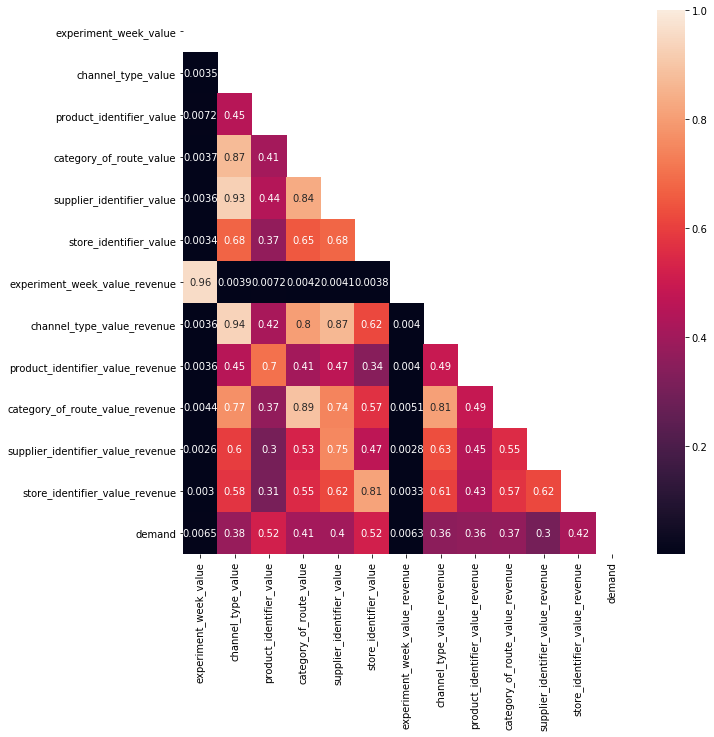

In [11]:
corr = data[cols].corr()
fig, ax = plt.subplots(figsize=(10, 10)) 
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(corr, mask= mask, ax= ax, annot= True)

### Drop Column 'experiment_week_value' and 'experiment_week_value_revenue'
* Droping column 'experiment_week_value' and 'experiment_week_value_revenue' as it is nearly a contant value

In [0]:
data.drop('experiment_week_value', axis = 1, inplace=True)
numAttributes.remove('experiment_week_value')
data.drop('experiment_week_value_revenue', axis = 1, inplace=True)
numAttributesRevenue.remove('experiment_week_value_revenue')

### Converting numAttributes to int16 datatype
* To save memory on RAM and setting values to round-up value, converting numAttributes to int16 datatype from float64 and numAttributesRevenue to float32 from float64

In [15]:
for cols in numAttributes:
  data[cols] = data[cols].astype('int16')
data.dtypes

channel_type_value                     int16
product_identifier_value               int16
category_of_route_value                int16
supplier_identifier_value              int16
store_identifier_value                 int16
channel_type_value_revenue           float64
product_identifier_value_revenue     float64
category_of_route_value_revenue      float64
supplier_identifier_value_revenue    float64
store_identifier_value_revenue       float64
demand                                 int64
dtype: object

In [16]:
for cols in numAttributesRevenue:
  data[cols] = data[cols].astype('float32')
data.dtypes

channel_type_value                     int16
product_identifier_value               int16
category_of_route_value                int16
supplier_identifier_value              int16
store_identifier_value                 int16
channel_type_value_revenue           float32
product_identifier_value_revenue     float32
category_of_route_value_revenue      float32
supplier_identifier_value_revenue    float32
store_identifier_value_revenue       float32
demand                                 int64
dtype: object

## Training and testing models

### Defining function for matrice.
* RMSE is the matrice used.

In [0]:
def matrice(model):
  y_predicted = model.predict(X_train)
  print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_predicted)))
  
  y_predicted = model.predict(X_test)
  print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_predicted)))

### Index of Starting of Week 5 data

In [13]:
indx = data[data['experiment_week'] == 'Week 5 of 2019'].index[0]
indx

42982034

### Dropping column 'experiment_week'

In [0]:
data.drop('experiment_week', axis = 1, inplace=True)

### Splitting train and validation data set

In [0]:
X_train = data.loc[:indx, data.columns != 'demand'].values
X_test = data.loc[indx:, data.columns != 'demand'].values

In [21]:
y_train = data.loc[:indx,'demand'].values
y_test = data.loc[indx:,'demand'].values
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42982035, 10), (42982035,), (10382849, 10), (10382849,))

### Modeling using Linear Regression

In [0]:
linearRegression = LinearRegression()  
linearRegression = linearRegression.fit(X_train, y_train)

In [23]:
matrice(linearRegression)

Train RMSE:  16.928583681676304
Test RMSE:  16.81194511538107


### Modeling using Decision Tree

In [0]:
decisionTree = tree.DecisionTreeRegressor()
decisionTree = decisionTree.fit(X_train, y_train)

In [25]:
matrice(decisionTree)

Train RMSE:  6.8295577912048
Test RMSE:  11.285578643424738


## Training models on whole dataset

### Setting up features and target from pre-processed dataset

In [0]:
X_train = data.loc[:, data.columns != 'demand'].values

In [19]:
y_train = data.loc[:,'demand'].values
X_train.shape, y_train.shape

((53364883, 10), (53364883,))

### Training and saving all the models

In [20]:
linearRegression = LinearRegression()
print('Training...')  
linearRegression = linearRegression.fit(X_train, y_train)
print('Done')
pickle.dump(linearRegression, open(path+'linearRegressionUnitRevenue.sav', 'wb'))
print('Model Saved')

Training...
Done
Model Saved


In [21]:
decisionTree = tree.DecisionTreeRegressor()
print('Training...') 
decisionTree = decisionTree.fit(X_train, y_train)
print('Done')
pickle.dump(decisionTree, open(path+'decisionTreeUnitRevenue.sav', 'wb'))
print('Model Saved')

Training...
Done
Model Saved
